#### Load libraries


In [1]:
import os
from os.path import join as pjoin

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PyComplexHeatmap as pch
import seaborn as sns
from joblib import Parallel, delayed
from matplotlib_venn import venn2, venn2_circles
from scipy import stats
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import QuantileTransformer

from omics_tools import association, enrichment, evaluation, multivariate, preprocessing


#### Load data

In [2]:
DATA_DIRECTORY = "/Users/ar3513/Code/data/"


In [3]:
data = pd.read_parquet(pjoin(DATA_DIRECTORY, "uc_gse109142_data_tpm.parquet")).set_index("sample_id")
data = data[data.columns[(data.median() > 0.02)]] # remove very lowly expressed genes

metadata = pd.read_parquet(pjoin(DATA_DIRECTORY, "uc_gse109142_metadata.parquet")).set_index("sample_id")

pathways = pd.read_parquet(pjoin(DATA_DIRECTORY, "pathways.parquet"))
pathways = pathways.query('pathway_name.str.contains("disease") == False', engine='python')
pathway_mapper = pathways.groupby("pathway_name")["gene_name"].apply(set).to_dict()


#### Data processing

In [4]:
PERCENTILE_VARIATION_THRESHOLD = 0.25


In [5]:
# Select the most variable genes (genes with MAD > PERCENTILE_VARIATION_THRESHOLD)
mad_values = data.apply(stats.median_abs_deviation, axis=0)
variable_genes = mad_values[mad_values > mad_values.quantile(PERCENTILE_VARIATION_THRESHOLD)].index.to_list()
data = data[variable_genes]

# Quantile-transformation of data
data_qt = preprocessing.quantile_transformation(data=data, n_quantiles=100)

# Inverse-normal transformation
data_normalised = preprocessing.inverse_normal_transformation(data)


#### Quick QC based on PCA

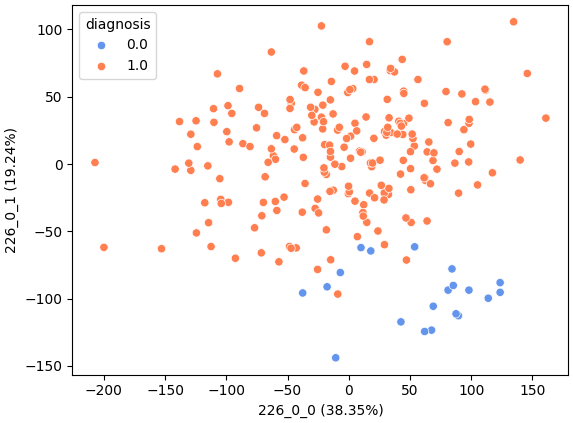

In [6]:
# PCA model
pca_model = multivariate.pca(data=data_normalised, n_components=np.min(data.shape), scale=True)

# Select components for plotting
PC_x = '226_0_0'
PC_y = '226_0_1'

# Get variance proportion of explained by PC_x and PC_y
var_x = np.round((pca_model.explained_variance_ratio.query(f"component == '{PC_x}'")["var"]*100).iloc[0], 2)
var_y = np.round((pca_model.explained_variance_ratio.query(f"component == '{PC_y}'")["var"]*100).iloc[0], 2)

# Plot the sample weights for the first two PCA components
sns.scatterplot(data=pca_model.sample_weights.join(metadata), 
                x=PC_x, 
                y=PC_y, 
                hue='diagnosis', 
                palette=
                {
                    0: 'cornflowerblue',
                    1: 'coral'
                }
               )

# Add labels and title
plt.xlabel(f"{PC_x} ({var_x}%)")
plt.ylabel(f"{PC_y} ({var_y}%)")

plt.show()


#### ICA

##### 1) Evaluate the reproducibility of ICA components depending on the number of components

,n_components,component_a,random_state_a,random_state_b,r2_max
0,1,0,0,1,1.0
1,1,0,0,2,1.0
2,1,0,0,3,1.0
3,1,0,0,4,1.0
4,1,0,0,5,1.0


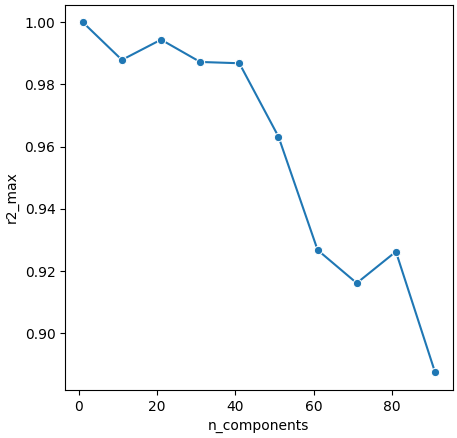

CPU times: user 1.84 s, sys: 1.34 s, total: 3.18 s
Wall time: 7min 8s


In [7]:
%%time

# For each value in `n_of_components`, it runs ICA multiple times with different 
# random states, keeping all other parameters constant. It then calculates the maximum correlation
# between each of the components of given run and all other components of another run.

metrics = Parallel(n_jobs=-1)(
    delayed(evaluation.lvm_reproducibility)(
        data=data_normalised,
        n_components=n_components, 
        n_random_states=10, 
        lvm_method=evaluation.LvmMethod.ICA
    )
    for n_components in range(1, 100, 10)
)
metrics = pd.concat(metrics)
metrics_nc_avg = (metrics
                  .groupby("n_components")
                  ["r2_max"]
                  .median()
                  .to_frame()
                  .reset_index()
                 ) # metrics aggregated by number of components (nc)
metrics_nc_rs_avg = (metrics
                     .groupby(["n_components", "random_state_a"])
                     ["r2_max"]
                     .median()
                     .to_frame()
                     .reset_index()
                    ) # metrics aggregated by number of components (nc) and random state (rs)

display(metrics.head()) # R2 is the maximum correlation between each of the components of given run and all other components of another run.

# Plot the average component similarity (R2_max) across all for the different number of components evaluated
plt.figure(figsize=(5, 5))
sns.lineplot(data=metrics.groupby("n_components")["r2_max"].median().to_frame().reset_index(),
                x="n_components", 
                y="r2_max", 
                marker="o"
               )
plt.show()


##### 2) Select the optimal number of ICA components
The optimal number of components (N) would be the largest N before the average reproducibility drops too low.

In [8]:
N_COMPONENTS = 41


##### 3) Select the optimal parameters (i.e. random state) for the selected number of components


In [9]:
model_parameters = metrics_nc_rs_avg[metrics_nc_rs_avg["n_components"] == N_COMPONENTS].sort_values("r2_max", ascending=False).iloc[0]


##### 4) Run the final ICA model

In [10]:
# Run ICA with the selected model parameters
ica_model = multivariate.ica(
    data=data_normalised, 
    n_components=model_parameters["n_components"].astype(int), 
    random_state=model_parameters["random_state_a"].astype(int)
    
)
feature_weights = ica_model.feature_weights.T.copy(deep=True)
sample_weights = ica_model.sample_weights.copy(deep=True)


##### 5) Derive the reproducibility/stability of each component of the final run
The reproducibility is measured by the maximum cross-correlation value of a given component across all components from other runs (with same number of components but different random state).

In [11]:
metrics_components = (
    metrics.query(f"n_components == {model_parameters['n_components']} & random_state_a == {model_parameters['random_state_a']}")
    .groupby(["n_components", "random_state_a", "component_a"])
    ["r2_max"]
    .max()
    .to_frame()
    .reset_index()
)
id_columns = ["n_components", "random_state_a", "component_a"]
metrics_components[id_columns] = metrics_components[id_columns].astype(str)
metrics_components.index = metrics_components.apply(lambda row: f"{row[id_columns[0]]}_{row[id_columns[1]]}_{row[id_columns[2]]}", axis=1)
metrics_components = metrics_components.drop(columns=id_columns)
metrics_components["r2_max"].describe() # consider excluding components with low reproducibility score


count    41.000000
mean      0.995474
std       0.008014
min       0.955280
25%       0.995896
50%       0.998348
75%       0.999075
max       0.999913
Name: r2_max, dtype: float64

#### Associations with clinical metadata

In [12]:
DIAGNOSIS_COLUMN = "diagnosis"
SEVERITY_COLUMNS = ["total_mayo_score", "histology_severity_score"]
PVAL_DIAGNOSIS_THRESHOLD = 1e-02
PVAL_SEVERITY_THRESHOLD = 1e-02


In [13]:
# Adjust the sign of the components, so that the disease group (1.0) is always on the 
# right side of the distribution of sample weights. This facilitates the interpretation
# of the subsequent analyses
median_values = (sample_weights
                 .join(metadata[DIAGNOSIS_COLUMN])
                 .groupby(DIAGNOSIS_COLUMN)
                 .median()
                 .T
                )
components_to_flip = median_values[median_values[1.0] < median_values[0.0]].index.to_list() # 1.0=disease, 0.0=control
components_not_flip = set(feature_weights.columns) - set(components_to_flip) 

feature_weights[components_to_flip] = -1*feature_weights[components_to_flip]
sample_weights[components_to_flip] = -1*sample_weights[components_to_flip]

# Ensure that the transformation is correct
np.testing.assert_array_equal(
    np.dot(ica_model.sample_weights.values, ica_model.feature_weights.values), 
    np.dot(sample_weights.values, feature_weights.T.values)
)


##### 1) Associations with diagnosis

In [14]:
associations_diagnosis = association.compare_distributions(
    continuous_variables=sample_weights,
    binary_variable=metadata["diagnosis"],
    method_category=association.AssociationMethodCategory.NON_PARAMETRIC,
    alternative_hypothesis=association.AlternativeHypothesis.TWO_SIDED,
    min_group_size=2,
).rename(columns={"feature": "component"})
associations_diagnosis.sort_values("pvalue").head()


,component,avg_group,avg_not_group,avg_group_ratio,pvalue,pfdr
29,41_7_29,0.024925,-0.202234,-0.123248,4.335463e-13,1.531087e-11
34,41_7_34,0.012856,-0.166514,-0.077205,9.280641e-13,1.531087e-11
32,41_7_32,0.019766,-0.297057,-0.066540,1.142752e-12,1.531087e-11
31,41_7_31,0.013305,-0.212235,-0.062688,1.728418e-12,1.531087e-11
28,41_7_28,0.015621,-0.298784,-0.052283,1.867179e-12,1.531087e-11


##### 2) Associations with severity

In [15]:
associations_severity = association.correlation(
    continuous_variables_a=sample_weights, 
    continuous_variables_b=metadata[SEVERITY_COLUMNS], 
    method_category=association.AssociationMethodCategory.NON_PARAMETRIC
).rename(columns={"feature_a": "component", "feature_b":"clinical_feature"})

associations_severity.sort_values("pvalue").head()


,component,clinical_feature,r,pvalue,pfdr
0,41_7_28,total_mayo_score,0.470159,1.002833e-12,2.608065e-11
0,41_7_7,total_mayo_score,0.468252,1.272227e-12,2.608065e-11
0,41_7_23,total_mayo_score,0.424960,1.932936e-10,2.641680e-09
0,41_7_25,total_mayo_score,0.412945,6.902029e-10,7.074580e-09
0,41_7_1,total_mayo_score,0.356433,1.453377e-07,1.191769e-06


##### 3) Overlap between diagnosis and severity associations

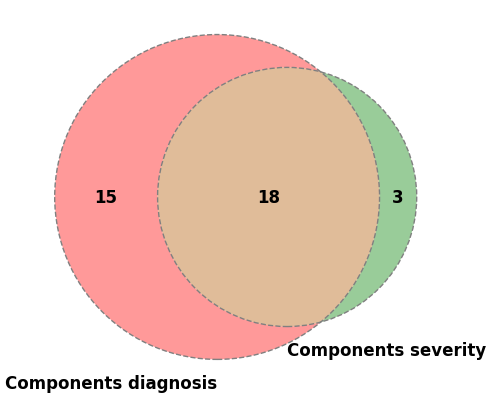

In [16]:
# Visualise the components associated with disease status and severity
components_diagnosis = set(associations_diagnosis.query("pfdr < @PVAL_DIAGNOSIS_THRESHOLD")["component"])
components_severity = set(associations_severity.query("pfdr < @PVAL_DIAGNOSIS_THRESHOLD & r>0")["component"])

plt.figure(figsize=(6, 5))

# Venn Diagram for two sets
venn = venn2([components_diagnosis, components_severity], ('Components diagnosis', 'Components severity'))
venn2_circles([components_diagnosis, components_severity], linestyle='dashed', linewidth=1, color='grey')

# Customize the appearance
for text in venn.set_labels:
    text.set_fontsize(12)
    text.set_fontweight('bold')

for text in venn.subset_labels:
    if text:  # Check if the subset label exists (it could be None)
        text.set_fontsize(12)
        text.set_fontweight('bold')

plt.show()


##### 4) Most relevant features of the ICA component of interest

In [17]:
COMPONENT = "41_7_28"
FEATURE_SELECTION_THRESHOLD = 0.15 # proportion of features to be selected from each tail


In [18]:
# Select features that are on the tails of the feature_weights distribution for the component of interest
feature_weights_component = feature_weights[COMPONENT]
feature_weight_thresholds = feature_weights_component.quantile([FEATURE_SELECTION_THRESHOLD, 1 - FEATURE_SELECTION_THRESHOLD]).to_list()

features_high = feature_weights_component[feature_weights_component > feature_weight_thresholds[1]].sort_values(ascending=False)
features_low = feature_weights_component[feature_weights_component < feature_weight_thresholds[0]].sort_values()

display(features_high.sort_values(ascending=False).head())
display(features_low.sort_values().head())


CYP4F3     7.090491
MGAM       6.724698
DGAT2      6.645914
ADGRG3     6.477277
PGLYRP1    6.392437
Name: 41_7_28, dtype: float64

PDGFD   -3.786191
MYOCD   -3.510912
SMAD6   -3.476385
VAT1L   -3.396476
ID1     -3.286528
Name: 41_7_28, dtype: float64

#### Enrichment analysis

In [19]:
# Pathways "upregulated"
pathways_enriched_high = enrichment.fisher(query=set(features_high.index), 
                                           annotation_mapper=pathway_mapper,
                                           space_size=data.shape[1]
                                          )
pathways_enriched_high.sort_values("pfdr").head()


,query,annotation_id,overlap,query_length,annotation_length,overlap_length,pvalue,pfdr
77,"{ANPEP, CFD, CLEC4D, HILPDA, HCK, FYB1, EPHB3,...",Cytokine-cytokine receptor interaction,"{IL10RA, CXCL16, CCR1, INHBB, TNF, IL1B, IL10R...",1820,298,93,6.669805e-13,1.834862e-10
271,"{ANPEP, CFD, CLEC4D, HILPDA, HCK, FYB1, EPHB3,...",Rheumatoid arthritis,"{ATP6V1B2, TCIRG1, HLA-DPA1, TNF, ATP6V1D, CD8...",1820,94,43,1.057558e-12,1.834862e-10
213,"{ANPEP, CFD, CLEC4D, HILPDA, HCK, FYB1, EPHB3,...",Osteoclast differentiation,"{SOCS1, SIRPB1, FCGR2A, LILRA6, TNF, FCGR3B, N...",1820,142,54,1.243780e-11,1.438639e-09
154,"{ANPEP, CFD, CLEC4D, HILPDA, HCK, FYB1, EPHB3,...",IL-17 signaling pathway,"{CSF3, S100A8, DEFB4A, TNFAIP3, TNF, S100A7, C...",1820,95,40,1.544552e-10,1.339899e-08
329,"{ANPEP, CFD, CLEC4D, HILPDA, HCK, FYB1, EPHB3,...",Viral protein interaction with cytokine and cy...,"{IL10RA, IL18RAP, IL6R, CCR1, TNF, CXCR1, PF4,...",1820,100,41,2.464575e-10,1.710415e-08


In [20]:
# Pathways "downregulated"
pathways_enriched_low = enrichment.fisher(query=set(features_low.index), 
                                          annotation_mapper=pathway_mapper,
                                          space_size=data.shape[1]
                                          )
pathways_enriched_low.sort_values("pfdr").head()


,query,annotation_id,overlap,query_length,annotation_length,overlap_length,pvalue,pfdr
175,"{FAM3C, KCNH2, PPP2CB, GPR63, DEFB1, CDK2AP1, ...",Lysosome,"{HEXA, MFSD8, HGSNAT, GNPTG, DMXL1, NPC1, CTSD...",1820,132,33,0.001734,0.601629
0,"{FAM3C, KCNH2, PPP2CB, GPR63, DEFB1, CDK2AP1, ...",2-Oxocarboxylic acid metabolism,"{BCKDHA, IDH2, GPT2}",1820,33,3,0.891443,1.000000
235,"{FAM3C, KCNH2, PPP2CB, GPR63, DEFB1, CDK2AP1, ...",Phosphatidylinositol signaling system,"{PIK3CA, PIK3R1, PLCB4, INPP1, PIK3C2B, PLCG1,...",1820,98,8,0.985618,1.000000
234,"{FAM3C, KCNH2, PPP2CB, GPR63, DEFB1, CDK2AP1, ...","Phenylalanine, tyrosine and tryptophan biosynt...",{},1820,6,0,1.000000,1.000000
233,"{FAM3C, KCNH2, PPP2CB, GPR63, DEFB1, CDK2AP1, ...",Phenylalanine metabolism,{},1820,16,0,1.000000,1.000000


In [21]:
# Pathways "disregulated"
pathways_enriched_both = enrichment.fisher(query=set(features_low.index)|set(features_high.index), 
                                          annotation_mapper=pathway_mapper,
                                          space_size=data.shape[1]
                                          )
pathways_enriched_both.sort_values("pfdr").head()


,query,annotation_id,overlap,query_length,annotation_length,overlap_length,pvalue,pfdr
271,"{FAM3C, ANPEP, CFD, KCNH2, CLEC4D, HILPDA, PPP...",Rheumatoid arthritis,"{ATP6V1B2, TCIRG1, CSF1, HLA-DPA1, TNF, ATP6V1...",3640,94,53,8.664842e-08,0.000030
213,"{FAM3C, ANPEP, CFD, KCNH2, CLEC4D, HILPDA, PPP...",Osteoclast differentiation,"{SOCS1, SIRPB1, FCGR2A, LILRA6, CSF1, TNF, FCG...",3640,142,71,4.153859e-07,0.000072
329,"{FAM3C, ANPEP, CFD, KCNH2, CLEC4D, HILPDA, PPP...",Viral protein interaction with cytokine and cy...,"{IL10RA, XCL2, IL18RAP, IL6R, CCR1, CSF1, TNF,...",3640,100,51,8.374865e-06,0.000969
154,"{FAM3C, ANPEP, CFD, KCNH2, CLEC4D, HILPDA, PPP...",IL-17 signaling pathway,"{CSF3, S100A8, DEFB4A, TNFAIP3, TNF, S100A7, C...",3640,95,48,2.104402e-05,0.001826
177,"{FAM3C, ANPEP, CFD, KCNH2, CLEC4D, HILPDA, PPP...",Malaria,"{ACKR1, CSF3, THBS2, SELE, TNF, KLRK1, SELP, I...",3640,50,28,1.128410e-04,0.007831


#### Heatmap of pathway genes

In [22]:
PATHWAY_NAME = "TNF signaling pathway"


In [23]:
pathway_genes = list(pathways_enriched_both.loc[pathways_enriched_both["annotation_id"] == PATHWAY_NAME, "overlap"].iloc[0])


Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 23.6375 mm


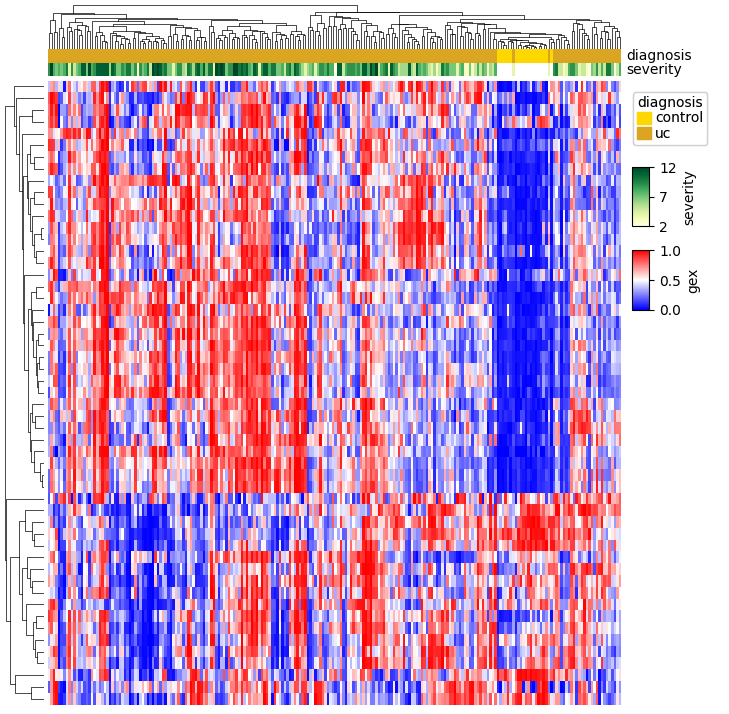

In [24]:
# Annotation for samples
col_ha = pch.HeatmapAnnotation(
    diagnosis=pch.anno_simple(
        metadata[DIAGNOSIS_COLUMN].map({0: 'control', 1: 'uc'}),
        colors={'control': 'gold', 'uc': 'goldenrod'},
        #add_text=True,
        legend=True
    ), 
    severity=pch.anno_simple(metadata[SEVERITY_COLUMNS[0]], cmap='YlGn')
)

# Heatmap
plt.figure(figsize=(8, 8))

pch.ClusterMapPlotter(data=data_qt[pathway_genes].T, 
                      cmap="bwr",
                      row_dendrogram=True, 
                      col_dendrogram=True, 
                      show_rownames=False,
                      show_colnames=False, 
                      label='gex',
                      top_annotation=col_ha
                     )

plt.show()